In [1]:
import os
import pickle

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
os.environ["JAX_NUMPY_RANK_PROMOTION"] = "raise"

In [2]:
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt
import scipy.sparse
import math
import optax

from jax import grad, jit, vmap, value_and_grad, random, config

config.update("jax_numpy_rank_promotion", "raise")

In [3]:
# We set up the parameters of the simulation. 

N_DAYS = 100000 # Number days

# Make sure these numbers are not equal to detect reshape related bugs ...
N_TASKS = 32 # Number of tasks
N_BINS = 8 # Number of time bins

# The size of the day representations
DIM = 32

key = random.PRNGKey(4530)

# Matrix A is the representation for each day
A = jnp.abs(random.normal(key, (N_DAYS, N_BINS, DIM))) / math.sqrt(DIM)

# Matrix B is the mapping from each patient representation to risk predictions
# This is effectively where I had my bug, I had N_TASKS, N_BINS
B = random.normal(key, (N_TASKS, DIM))

# The hazards for each day, of shape (N, N_TASKS, N_BINS)
hazards = jnp.exp2(jnp.tensordot(A, B.T, axes=1))

assert hazards.shape == (N_DAYS, N_BINS, N_TASKS)

# We have to setup our bins
bins = jnp.concatenate((jnp.linspace(0, 3, num=N_BINS), jnp.array([float('inf')])))
assert bins.shape == (N_BINS + 1,)
print("Working with ", bins)

Working with  [0.         0.42857146 0.8571429  1.2857144  1.7142859  2.1428573
 2.5714288  3.                inf]


In [4]:
# Perform our sampling for our simulation
# We need to sample an actual event time for each day and task
# We use inverse cdf sampling to easily compute samples

# Given a time point t and a single hazard vector, compute P(surv >= t)
def compute_survival(t, hazard):
    in_bin = t >= bins[:-1]
    time_in_bin = -hazard * (jnp.minimum(jnp.expand_dims(t, 0), bins[1:]) - bins[:-1])
    return jnp.exp((time_in_bin * in_bin).sum())

# Inverse of compute survival, given a probablitly p and a single hazard vector, compute t such that P(surv >= t) = p 
def sample(p, hazard):
    log_p = jnp.expand_dims(jnp.log(p), -1)    
    val_in_each_bin = -hazard * (bins[1:] - bins[:-1])
    
    assert len(hazard.shape) == 1
    assert hazard.shape[0] == bins.shape[0] - 1
    
    end_bin = jnp.cumsum(val_in_each_bin, axis=0)
    start_bin = jnp.concatenate((jnp.array([0]), end_bin[:-1]))
    
    within_bin = jnp.logical_and(log_p <= start_bin, log_p > end_bin)
    
    time = bins[:-1] + (log_p - start_bin) / (-hazard)
    
    return (time * within_bin).sum()


compute_survival_for_day = jit(vmap(compute_survival, (0, None)))
compute_survival_for_all = jit(vmap(vmap(compute_survival, (-1, -1))))

sample_for_day = jit(vmap(sample))
sample_for_all = jit(vmap(vmap(sample, (-1, -1))))

# Randomly sample a probaiblity for each day and task
probs = random.uniform(key, (N_DAYS, N_TASKS))

event_times = sample_for_all(probs, hazards)

assert event_times.shape == (N_DAYS, N_TASKS)

reverse_probs = compute_survival_for_all(event_times, hazards)

# Double check that our functions are actually inverses ...
assert jnp.allclose(probs, reverse_probs, atol=1e-4)


<Figure size 640x480 with 0 Axes>

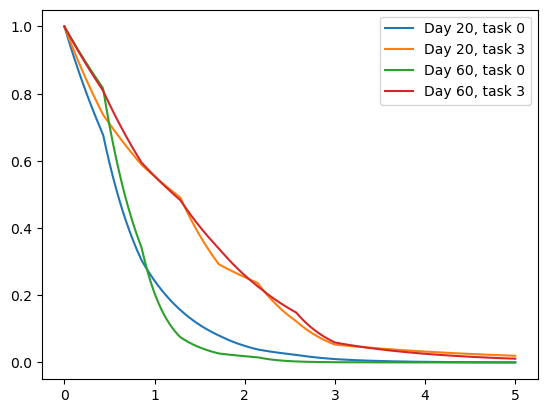

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot the events to get a sense of what these distributions look like

i = 80
x = jnp.linspace(0, 5, 1000)

plt.plot(x, compute_survival_for_day(x, hazards[20, :, 0]), label="Day 20, task 0")
plt.plot(x, compute_survival_for_day(x, hazards[20, :, 3]), label="Day 20, task 3")
plt.plot(x, compute_survival_for_day(x, hazards[60, :, 0]), label="Day 60, task 0")
plt.plot(x, compute_survival_for_day(x, hazards[60, :, 3]), label="Day 60, task 3")
plt.legend()
plt.figure()

In [6]:
# Each day has a censor time

censor_params = {'c':2, 'scale':2}

# Funny enough scipy is the slowest part of this entire simulation
censor_times = jnp.array(scipy.stats.weibull_min.rvs(**censor_params, size=N_DAYS))

assert censor_times.shape == (N_DAYS,)

times = jnp.minimum(jnp.expand_dims(censor_times, 1), event_times)

assert times.shape == (N_DAYS, N_TASKS)

is_event = jnp.array(jnp.expand_dims(censor_times, 1) > event_times)

assert is_event.shape == (N_DAYS, N_TASKS)

print('Censorship rate is ', 1 - jnp.mean(is_event))

Censorship rate is  0.23622501


In [7]:
# We need to compute the time in each bin for every day and every task

tiled_bins = jnp.expand_dims(jnp.expand_dims(bins, 0), -1)
print(tiled_bins.shape)

tiled_times = jnp.expand_dims(times, 1)

print('time', tiled_times.shape)

time_in_bin = jnp.clip(
        tiled_times - tiled_bins[:, :-1, :], 
        0, 
        tiled_bins[:, 1:, :] - tiled_bins[:, :-1, :]
)

log_time_in_bin = jnp.log2(time_in_bin)

assert time_in_bin.shape == (N_DAYS, N_BINS, N_TASKS)
assert log_time_in_bin.shape == (N_DAYS, N_BINS, N_TASKS)

# Marker of whether it is in the bin
within_bin =  jnp.logical_and(tiled_bins[:, :-1, :] <= tiled_times,
                                  tiled_times < tiled_bins[:, 1:, :])

assert within_bin.shape == (N_DAYS, N_BINS, N_TASKS)

(1, 9, 1)
time (100000, 1, 32)


In [8]:
# Note that the above datastructures, time_in_bin and within_bin are sparse
# We can take advantage of that to significantly improve our training time

# Get the indices when an event actually happens
is_event_indices = jnp.reshape(jnp.expand_dims(is_event, 1) * within_bin, (-1, N_TASKS))
print(is_event_indices.shape)
assert is_event_indices.shape == (N_DAYS * N_BINS, N_TASKS)
a, b = jnp.where(is_event_indices)
event_indices = jnp.stack((a, b), axis=-1).astype(jnp.uint32)
print(event_indices.shape, jnp.sum(is_event))
assert event_indices.shape == (jnp.sum(is_event), 2)
print("Original size for events", is_event_indices.shape[0] * is_event_indices.shape[1])
print("Reduced size for events", event_indices.shape[0] * event_indices.shape[1])


# Convert the time in each bin to a sparse data structure
# Note that this is currently a dummy implementation doesn't actually use the sparse structure

log_time_in_bin_sparse = scipy.sparse.csr_matrix(log_time_in_bin.reshape(-1, N_TASKS))
assert log_time_in_bin_sparse.shape == (N_DAYS * N_BINS, N_TASKS)


sparse = (
    jnp.array(log_time_in_bin_sparse.indptr, dtype=jnp.uint32), 
    jnp.zeros((log_time_in_bin_sparse.indptr.shape[0] - 1,), dtype=jnp.float32), 
    jnp.array(log_time_in_bin_sparse.indices, dtype=jnp.uint32), 
    jnp.array(log_time_in_bin_sparse.data, dtype=jnp.float32),
)

(800000, 32)
(2444080, 2) 2444080
Original size for events 25600000
Reduced size for events 4888160


In [42]:
# Now we have to estimate B using backpropegation

import piton.jax

full = jnp.float32
compute_dtype = jnp.float16

key = random.PRNGKey(2312)
learned_B = random.normal(key, (N_TASKS, DIM), full)

assert learned_B.shape == B.shape

A_half = A.astype(compute_dtype)
reshaped_A = A_half.reshape(-1, DIM)

from jax import debug

def compute_loss(current_B, times, is_event, scale_factor):
    # The event component of the loss
    event_loss = -(math.log(2) * piton.jax.embedding_dot(reshaped_A, current_B, event_indices).sum(dtype=full)
        / (reshaped_A.shape[0] * current_B.shape[0]))
    
    # The survival component of the loss
    survival_loss = piton.jax.exp_mean(reshaped_A, current_B, sparse) 

    return scale_factor * (event_loss + survival_loss)

@jit
def step(params, opt_state, times, is_event, factor):
    loss, grads = value_and_grad(compute_loss)(params.astype(compute_dtype), times, is_event, factor)
    loss = loss.astype(full)
    loss /= factor
    grads = grads.astype(full) 
    grads /= factor
    
    updates, opt_state = optimizer.update(grads, opt_state, params)
    # debug.print("{a}",a=updates)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

import time

optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(learned_B)

factor = 100
for i in range(10000):
    learned_B, opt_state, loss = step(learned_B, opt_state, times, is_event, factor)
    # print(loss)
    if i == 1000:
        start = time.time()
    if i % 1000 == 0:
        # max_g = jnp.max(jnp.abs(g))
        # factor = min(1/ max_g, 1000) 
        print('Finished iter', loss, learned_B[0,:], B[0,:], factor)
    
end = time.time()

print(end -start)

Finished iter 0.10819021 [ 0.17790662 -0.25128275  0.13631624  2.3515677  -1.4374462  -1.1171622
 -0.47728905  1.0983169   0.6191998  -1.5319699  -0.5866256  -1.0360315
 -1.3091217  -0.13144937  1.017583    0.37147313  0.6908593   0.4712878
 -0.07914373  1.1206933  -2.81158     1.025498   -1.0395764   1.0967298
 -1.0760361   1.8676846  -0.28361854 -0.60766006 -1.2496394   1.5331829
  0.67406726  1.4598019 ] [-0.565912   -1.5690621   0.5907707   2.586395    0.4615626   0.7048454
  0.05645976 -0.98668736  2.0144467   1.5468168   0.17344667  1.1737946
  1.4688553  -1.0907745  -0.3574695  -0.8026156  -1.9873455   0.256871
  0.6719584   1.4950434   0.18909642 -0.6285447  -0.25080016  0.4701413
 -2.078669   -0.16969599  1.150056    1.4562176  -0.29004136 -0.1963456
 -0.36973226  0.40381137] 100
Finished iter 0.08028931 [ 0.24951315 -0.3228816   0.36887205  2.5390174  -1.1009971  -0.7832476
 -0.2382799   0.8456751   0.92577547 -1.1549091  -0.32293764 -0.6875933
 -0.9425709  -0.11498767  0.918

[0.45992506 0.6985204  0.48386487 0.81257147 0.9291262  0.9369831
 2.2158215  0.819917  ]
[0.49398735 0.7197358  0.4843982  0.82603514 0.9374207  0.9874443
 2.1350417  0.8323736 ]
[0.         0.42857146 0.8571429  1.2857144  1.7142859  2.1428573
 2.5714288  3.                inf]


<Figure size 640x480 with 0 Axes>

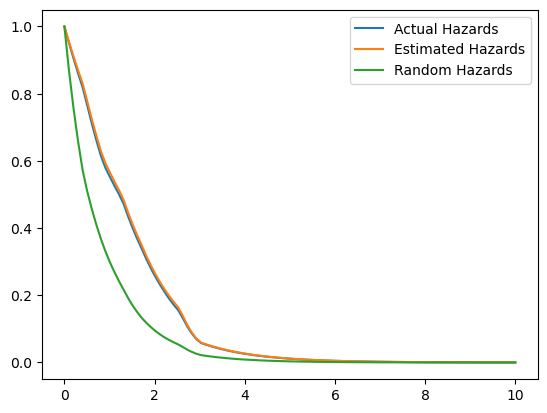

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot the results to see how well we did

key = random.PRNGKey(23123446)

estimated_hazards = jnp.exp2(jnp.tensordot(A, learned_B.T, axes=1))
random_hazards =  jnp.exp2(jnp.tensordot(A, random.normal(key, (N_TASKS, DIM), full).T, axes=1))

i = 60
task = 3

x = jnp.linspace(0, 10, 100)

print(estimated_hazards[i, :, task])
print(hazards[i, :, task])

print(bins)

plt.plot(x, compute_survival_for_day(x, hazards[i, :, task]), label="Actual Hazards")
plt.plot(x, compute_survival_for_day(x, estimated_hazards[i, :, task]), label="Estimated Hazards")
plt.plot(x, compute_survival_for_day(x, random_hazards[i, :, task]), label="Random Hazards")
plt.legend()
plt.figure()

In [ ]:
def blah(a, x):
    return a + x

blah_jit = jit(blah)

print(blah_jit(jnp.zeros((3,)), 10))
print(blah_jit(jnp.zeros((3,)), 50))